In [1]:
from platform import python_version
python_version()

'3.9.7'

# Supervised Learning (All Text)

In [2]:
#pip install gensim

In [3]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk import word_tokenize
from sklearn.model_selection import cross_validate
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('reviews_authors_genres.csv', usecols = ['review_text', 'rating', 'sentiment', 'language_code'])
df.head()

,review_text,rating,sentiment,language_code
0,So the low rating on this one is primarily bec...,2,bad,NaN
1,Find all of my reviews at: http://52bookminimu...,2,bad,NaN
2,Meh. Not for me. I don't really like historica...,1,bad,NaN
3,This series progressively got worse with each ...,1,bad,NaN
4,"llG@ jyd@, ltshbyht m`br@, lqS@ mtkrr@, w lbd ...",1,bad,NaN


In [5]:
language = ['eng', 'en-CA', 'en-GB', 'en-US']

df = df[df['language_code'].isin(language)]
#df.head()
len(df)

114566

In [6]:
options = ['good', 'bad']

df = df[df['sentiment'].isin(options)]
len(df)

76860

In [7]:
df_reviews = df.copy()

In [8]:
#drop na's from the dataframe.
df_reviews.dropna(inplace=True)

#check to see if all null values were removed.
df_reviews.isnull().sum()

review_text      0
rating           0
sentiment        0
language_code    0
dtype: int64

In [9]:
#A contractions dictionary from Wikipedia found on Stack Overflow for expanding contractions: 
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [10]:
import re

#This code is code to expand contractions in text created by Abhishek Sharma:
#https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

#Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

#Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df_reviews['review_text']=df_reviews['review_text'].apply(lambda x:expand_contractions(x))

In [11]:
#make all reviews lowercase.
df_reviews['review_text'] = df_reviews['review_text'].apply(lambda x: x.lower())

In [12]:
#check text after expanding contractions and lowercasing all words.
df_reviews['review_text'].unique()[0]

"this has got to be the most ridiculous book i have ever read. mostly for the plethora of basic historical mistakes that could have been checked with a 5 minutes google search. \n ms mccray has the citizens of republican rome (bce) eating tomatoes and potatoes and knowing about chocolate (these items did not arrive in europe until the late 16th century) and pasta (it did not arrive in italy until marco polo returned from china in the late 13th century). \n also, ms. mccray obviously has no idea about the naming protocol in rome. julius was not caesar's first name it was his last name and his daughter was julia, not his wife. \n and why did she feel the need to rename brutus's wife and mother. they were hardly unknown. his wife was porcia catonis and his mother the famous servillia. \n i would not recommend this book to anyone and would give it -5 stars if i could."

In [13]:
#removing digits and words that contain digits because the numbers don't have much weight importance.
df_reviews['review_text']=df_reviews['review_text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [14]:
import string

#This code is code to expand contractions in text created by Abhishek Sharma:
#https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
df_reviews['review_text']=df_reviews['review_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#removing all newline '\n' characters
df_reviews = df_reviews.replace(r'\n',' ', regex=True) 

#removing all excess space.
df_reviews['review_text']=df_reviews['review_text'].apply(lambda x: re.sub('\s+',' ',x))


#Let's take another look at the text.
df_reviews['review_text'].unique()[0]

'this has got to be the most ridiculous book i have ever read mostly for the plethora of basic historical mistakes that could have been checked with a minutes google search ms mccray has the citizens of republican rome bce eating tomatoes and potatoes and knowing about chocolate these items did not arrive in europe until the late century and pasta it did not arrive in italy until marco polo returned from china in the late century also ms mccray obviously has no idea about the naming protocol in rome julius was not caesars first name it was his last name and his daughter was julia not his wife and why did she feel the need to rename brutuss wife and mother they were hardly unknown his wife was porcia catonis and his mother the famous servillia i would not recommend this book to anyone and would give it stars if i could'

<AxesSubplot:>

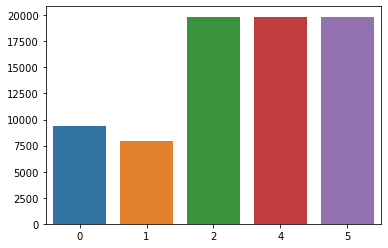

In [15]:
rate_cnt = df_reviews['rating'].value_counts()
rate_cnt = rate_cnt.sort_index()

x=rate_cnt.index
y=rate_cnt.values

sns.barplot(x=x,y=y)

In [16]:
# let's treat 4 and 5 as positive reviews and 1 and 2 as negative sentiment. 
# We will take 3 (neutral) reviews out

df_reviews = df_reviews[df_reviews.rating != 3]
pd.set_option('mode.chained_assignment',None)
df_reviews['labels'] = df_reviews['rating'].apply(lambda x:1 if x < 3 else 0) # Pos is 0 , neg is 1
df_reviews = df_reviews.drop(["rating","sentiment","language_code"],axis=1)
df_reviews.head()
print(len(df_reviews))

76816


In [17]:
# find baseline ==> since there are more positives than negatives
# baseline model can be one that simply labels every review as Class 0

print("{:.2f}".format(df_reviews[df_reviews.labels == 0].shape[0]/df_reviews.shape[0]))

0.52


In [18]:
train, test = train_test_split(df_reviews,test_size=0.3,stratify=df_reviews['labels'],random_state=42)

In [20]:
y_train = train['labels'].values
y_test = test['labels'].values

In [ ]:
scaler = StandardScaler(with_mean = False)

In [19]:
start = time.time()

cv = CountVectorizer(binary=True, min_df=10,max_df=0.95)
cv.fit_transform(train['review_text'].values)

X_train_cvec = cv.transform(train['review_text'].values)
X_test_cvec = cv.transform(test['review_text'].values)

#scale vector
X_train_cvec = scaler.fit_transform(X_train_cvec)
X_test_cvec = scaler.transform(X_test_cvec)

print("Time took to convert text into vector: ", round((time.time() - start)/60,2), " mins")

Time took to convert text into vector:  0.15  mins


In [21]:
start_time = time.time()

tfidf_v = TfidfVectorizer(use_idf=True, min_df = 10, max_df = 0.95)
tfidf_v.fit_transform(train['review_text'].values)

X_train_tvec = tfidf_v.transform(train['review_text'].values)
X_test_tvec = tfidf_v.transform(test['review_text'].values)

#scale vector
X_train_tvec = scaler.fit_transform(X_train_tvec)
X_test_tvec = scaler.transform(X_test_tvec)

print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.15  mins


In [22]:
from sklearn.svm import SVC

In [23]:
#start_time = time.time()

#clf_svm = SVC()
#scoring = 'accuracy'

#svm_scoret = cross_validate(clf_svm, X_train_tvec, y_train, scoring = scoring, cv = 10)
#svm_scorew = cross_validate(clf_svm, X_train_wvec_avg, y_train, scoring = scoring, cv = 10)
#svm_scorec = cross_validate(clf_svm, X_train_cvec, y_train, scoring = scoring, cv = 10)

#print("Time takes to cross validate: ", round((time.time() - start_time)/60, 2), " mins")

In [24]:
#print("tfidvectorizer cross validation score: ", svm_scoret["test_score"].mean())
#print("word2vec cross validation cross validation score: ", svm_scorew["test_score"].mean())
#print("count vectorizer cross validation score: ", svm_scorec["test_score"].mean())

In [25]:
#Create SVM model
clf_svm = SVC(random_state = 42, kernel = 'linear')

In [26]:
#tfid model fit and prediction
start_time = time.time()

svm_tmodel = clf_svm.fit(X_train_tvec, y_train)
y_predt = svm_tmodel.predict(X_test_tvec)

print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  55.2  mins


In [ ]:
coef = svm_tmodel.coef_.toarray().ravel()
top_pos = np.argsort(coef)[-10:]
top_neg = np.argsort(coef)[:10]
stack_coef = np.hstack([top_neg, top_pos])
feature_names = np.array(tfidf_v.get_feature_names_out())
#print(feature_names[stack_coef])

plt.figure(figsize = (15, 5))
color = ['blue' if c < 0 else 'magenta' for c in coef[stack_coef]]

plt.title('Tfidvectorizer Top 10 Negative and Positive Words')
plt.xlabel('Coefficient')
plt.ylabel('Words')
plt.bar(np.arange(2 * 10), coef[stack_coef], color = color)
plt.legend()
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names[stack_coef], rotation = 60, ha = 'right')
plt.show()

In [27]:
#count vec model fit and prediction
start_time = time.time()

svm_cmodel = clf_svm.fit(X_train_cvec, y_train)
y_predc = svm_cmodel.predict(X_test_cvec)

print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  56.29  mins


In [ ]:
coef = svm_cmodel.coef_.toarray().ravel()
top_pos = np.argsort(coef)[-10:]
top_neg = np.argsort(coef)[:10]
stack_coef = np.hstack([top_neg, top_pos])
feature_names = np.array(cv.get_feature_names_out())
#print(feature_names[stack_coef])

plt.figure(figsize = (15, 5))
color = ['blue' if c < 0 else 'magenta' for c in coef[stack_coef]]

plt.title('Countvectorizer Top 10 Negative and Positive Words')
plt.xlabel('Coefficient')
plt.ylabel('Words')
plt.bar(np.arange(2 * 10), coef[stack_coef], color = color)
plt.legend()
plt.xticks(np.arange(1, 1 + 2 * 10), feature_names[stack_coef], rotation = 60, ha = 'right')
plt.show()

In [28]:
#create a function that finds accuracy, f1 scores, precision, and recall scores for each model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(index_title, y_pred, y_true):
    score_dict = {}
    score_dict['accuracy'] = accuracy_score(y_true, y_pred)
    score_dict['precision'] = precision_score(y_true, y_pred)
    score_dict['recall'] = recall_score(y_true, y_pred)
    score_dict['f1_score'] = f1_score(y_true, y_pred)
    
    index = [index_title]
    
    df = pd.DataFrame(score_dict, index = index)
    
    return df

In [29]:
#model evaluation
t_eval = evaluate('tfidvectorizer', y_predt, y_test)
c_eval = evaluate('tfidvectorizer', y_predc, y_test)

frames = [t_eval, c_eval]
pd.concat(frames)

print("The accuracy, precision, recall, and f1_score for tfidvectorizer is: ", round(evaluate(y_predw, y_test), 3))

The accuracy, precision, recall, and f1_score for tfidvectorizer is:  (0.8391408114558473, 0.8505519388621569, 0.8093912731190519, 0.8294612872061462)
The accuracy, precision, recall, and f1_score for tfidvectorizer is:  (0.826903883705793, 0.8308190652475705, 0.8059795295385168, 0.8182108189399808)


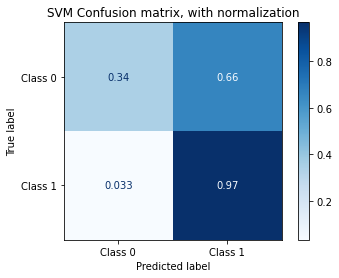

In [30]:
#confusion matrix for tfidvectorizer

conf_mat = metrics.plot_confusion_matrix(svm_tmodel, X_test_tvec, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
conf_mat.ax_.set_title('SVM Tfidvectorizer Confusion matrix, with normalization');

In [ ]:
conf_mat = metrics.plot_confusion_matrix(svm_cmodel, X_train_cvec, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
conf_mat.ax_.set_title('SVM Countvectorizer Confusion matrix, with normalization');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d88850fe-1254-48df-812c-7b92bc9ba01d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>